In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,LabelEncoder

In [3]:
df = pd.read_csv('Findata.csv')
df = df.dropna()
print(df.head())
print(df.describe().round(2))


   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
             step       amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
count  1048575.00   1048

In [4]:
label_encoders = {}
for col in ["type", "nameOrig", "nameDest"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

scaler = StandardScaler()
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])    

print(df.head())

       step  type    amount  nameOrig  oldbalanceOrg  newbalanceOrig  \
0 -1.662022     3 -0.561738    125164      -0.236855       -0.243832   
1 -1.662022     3 -0.591840    361319      -0.286956       -0.290673   
2 -1.662022     4 -0.598194    165236      -0.294045       -0.297117   
3 -1.662022     1 -0.598194    961662      -0.294045       -0.297117   
4 -1.662022     3 -0.554837    567915      -0.280123       -0.287183   

   nameDest  oldbalanceDest  newbalanceDest    isFraud  isFlaggedFraud  
0    274917       -0.425883       -0.461062  -0.033019             0.0  
1    286716       -0.425883       -0.461062  -0.033019             0.0  
2     73550       -0.425883       -0.461062  30.285174             0.0  
3     65464       -0.416661       -0.461062  30.285174             0.0  
4    138001       -0.425883       -0.461062  -0.033019             0.0  


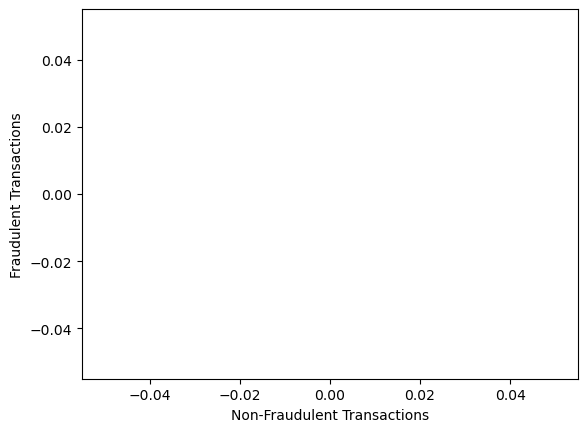

In [5]:
plt.scatter(x=df[df['isFraud'] == 0]['amount'], y=df[df['isFraud'] == 0]['amount'])
plt.xlabel('Non-Fraudulent Transactions')
plt.ylabel('Fraudulent Transactions')
plt.show()

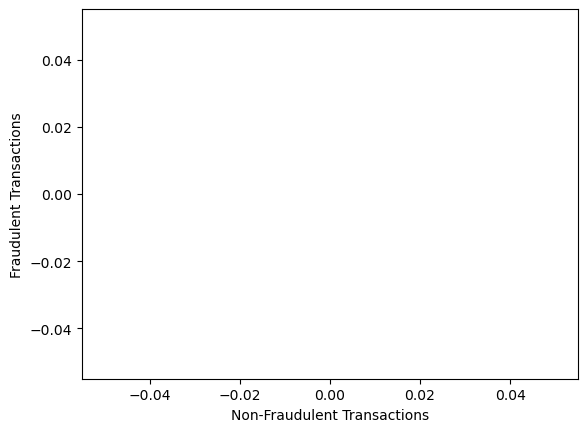

In [6]:
plt.scatter(x=df[df['isFraud'] == 1]['amount'], y=df[df['isFraud'] == 1]['amount'])
plt.xlabel('Non-Fraudulent Transactions')
plt.ylabel('Fraudulent Transactions')
plt.show()

In [7]:
X = df.drop(columns=["isFraud", "isFlaggedFraud"], errors='ignore')
y = df["isFraud"]


X.shape, y.shape


((1048575, 9), (1048575,))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(838860, 9) (209715, 9) (838860,) (209715,)


In [9]:
from xgboost import XGBClassifier

# Convert y_train and y_test to binary classes
y_train_binary = (y_train > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

clf_xgb = XGBClassifier(scale_pos_weight=(len(y_train_binary) - sum(y_train_binary)) / sum(y_train_binary), random_state=42)
clf_xgb.fit(X_train, y_train_binary)

y_pred = clf_xgb.predict(X_test) 

print("supervised learning")
print(accuracy_score(y_test_binary, y_pred))
print(classification_report(y_test_binary, y_pred))   

supervised learning
0.9996566769186753
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       0.84      0.85      0.84       228

    accuracy                           1.00    209715
   macro avg       0.92      0.93      0.92    209715
weighted avg       1.00      1.00      1.00    209715



In [10]:
#from sklearn.ensemble import RandomForestClassifier

#clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
#clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)

#print("Supervised Learning - Random Forest Classifier")
#print("Accuracy:", accuracy_score(y_test, y_pred))
#print(classification_report(y_test, y_pred))
# inconsistent results

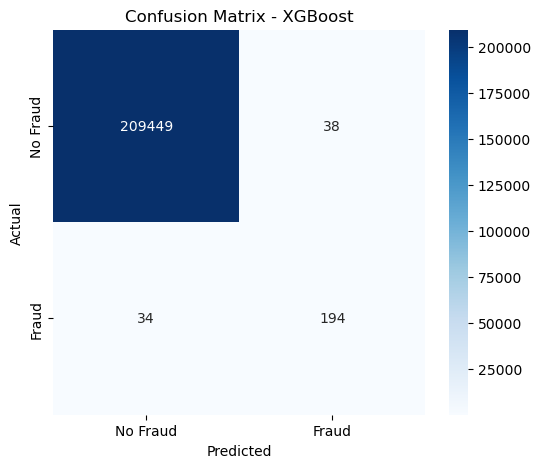

In [11]:
import seaborn as sns

# Convert y_test to binary classes
y_test_binary = (y_test > 0).astype(int)

plt.figure(figsize=(6,5))
cm_xgb = confusion_matrix(y_test_binary, y_pred)
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

In [12]:
#unsupervised learning using isolation forest and dbscan to detect anomalies and cluster fraud transactions
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.1, random_state=42)
df["fraud_prediction"] = iso_forest.fit_predict(X)
df["fraud_prediction"] = df["fraud_prediction"].apply(lambda x: 1 if x == -1 else 0) # 0=normal, 1=fraud

# Convert isFraud to binary classes
df["isFraud_binary"] = df["isFraud"].apply(lambda x: 1 if x > 0 else 0)

print(df["fraud_prediction"].value_counts())






fraud_prediction
0    943717
1    104858
Name: count, dtype: int64


In [13]:
from sklearn.cluster import DBSCAN

# Ensure isFraud_binary column exists
df["isFraud_binary"] = df["isFraud"].apply(lambda x: 1 if x > 0 else 0)

dbscan = DBSCAN(eps=0.5, min_samples=5)
df['Cluster'] = dbscan.fit_predict(df.drop(columns=["isFraud", "isFlaggedFraud", "fraud_prediction"], errors='ignore'))

print(df['Cluster'].value_counts())

    


Cluster
-1    1048575
Name: count, dtype: int64


In [14]:
df[numerical_columns] = scaler.inverse_transform(df[numerical_columns])
for col, le in label_encoders.items():
    df[col] = le.inverse_transform(df[col])

In [15]:
print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0   1.0   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1   1.0   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2   1.0  TRANSFER    181.00  C1305486145          181.0            0.00   
3   1.0  CASH_OUT    181.00   C840083671          181.0            0.00   
4   1.0   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  \
0  M1979787155             0.0             0.0      0.0             0.0   
1  M2044282225             0.0             0.0      0.0             0.0   
2   C553264065             0.0             0.0      1.0             0.0   
3    C38997010         21182.0             0.0      1.0             0.0   
4  M1230701703             0.0             0.0      0.0             0.0   

   fraud_prediction  isFraud_binary  Cluster  
0                 0               0       -1  
1   

In [16]:
df.to_csv('Traineddata1.csv', index=False)
